In [10]:
import sys
sys.path.insert(0,'..')
from run import Prepro
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from utils import utils_tensor as utils 
import tensorly as tl #tensorly package
from tensorly.decomposition import tucker #tucker decomp package
from utils import utils_tensor as utils 
import torch 

In [11]:
#load data 
#vision_data = np.load('data/vision_data_30_16_120_3years_test2.npy', allow_pickle = True)
vision_data = np.load('../data/vision_data_50_20_60_3years_v2.npy', allow_pickle = True)
# vision_data = np.load('../../../Volumes/Samsung_T5/vision_data_50_20_90_1980_v3.npy', allow_pickle = True)
#y = np.load('data/y_30_16_120_3years_test2.npy', allow_pickle = True)
stat_data = np.load('../data/y_50_20_60_3years_v2.npy', allow_pickle = True) 
# y = np.load('../../../Volumes/Samsung_T5/y_50_20_90_1980_v3.npy', allow_pickle = True) 

In [12]:
print(vision_data.shape)
print(stat_data.shape)

(83, 60, 3, 3, 25, 25)
(83, 60, 11)


In [90]:
class tensor_regression(torch.nn.Module):

    def __init__(self, x_stat, x_viz): 
        super(tensor_regression, self).__init__()
        v=1e-2 
        k=10
        self.W1 = torch.nn.Parameter(torch.randn(x_stat.shape[1], x_stat.shape[2] ) * v)
        self.V1 = torch.nn.Parameter(torch.randn(x_viz.shape[1], x_viz.shape[2], x_viz.shape[3], x_viz.shape[4]) * v)
#         self.W2 = torch.nn.Parameter(torch.randn(k)*v)
#         self.V2 = torch.nn.Parameter(torch.randn(k)*v)
#         self.b11 = torch.nn.Parameter(torch.rand(1)) #scalar 
#         self.b12 = torch.nn.Parameter(torch.rand(1))
        self.b2 = torch.nn.Parameter(torch.rand(1))
        

    def forward(self, x_stat, x_viz):
        'element-wise dot product + bias'
        #maybe this could be more elaborate, e.g. for each time step, do mapping, and then regress along time steps etc. 
        y1 = torch.einsum('nij,ij->n', x_stat, self.W1) #broadcast for each sample 
        z1 = torch.einsum('nijkl,ijkl->n',x_viz, self.V1)
#         y2 = torch.einsum('nk,k->n', y1, self.W2) + self.b11
#         z2 = torch.einsum('nk,k->n', z1, self.V2) + self.b12
#         y_hat = y2+z2+self.b2 #bias term 
        y_hat = y1+z1+self.b2 #bias term  
        
        return y_hat #vector of dim: n (sample size)

def schatten_norm(tensor, inner_ord=1, outer_ord=1):   #inner_ord=1 means nuclear norm 
    tensor = tensor.detach().numpy()
    inner_norm = []
    for i in range(len(tensor.shape)): #number of dimensions  
        #get norm for each unfolding 
        unfold = tl.unfold(tensor, i)
        s_vals= np.linalg.svd(unfold, full_matrices=False, compute_uv=False)
        inner_norm.append(np.linalg.norm(s_vals, ord=inner_ord)) 
    outer_norm = np.linalg.norm(inner_norm, ord=outer_ord)
    return outer_norm 

def loss_fn(y_hat, y):
    loss =  (y_hat - y).pow(2).sum() 
    reg = schatten_norm(y_hat, inner_ord = 1, outer_ord = 1)
    lam=20
    loss = loss + lam* reg 
    return loss

In [86]:
#vision data reduce dims 
def viz_reduce(tensors, core_ranks): #input: tensors, sample_size = first dimension
    tensors = tensors.numpy()
    #low rank decomp
    core_out = np.zeros((tensors.shape[0], core_ranks[0], core_ranks[1], core_ranks[2], core_ranks[3]))
    approx_error = 0 
    for i in range(tensors.shape[0]):
        tensor = tensors[i]
        core, factors = tucker(tensor, core_ranks)
        core_out[i,:,:,:] = core 
        #calculate approximation error
        approx = utils.tucker_to_tensor(core, factors)
        approx_error +=  tl.norm(approx-tensor)/tl.norm(tensor)*100  #euclidean norm
    approx_error = approx_error/tensors.shape[0]
    
    core_out = torch.tensor(core_out).float()
    print('approximation error=', approx_error)
    return core_out,  approx_error



In [87]:
#standardize x:
def standardize_x(x_viz_train, x_viz_test, x_stat_train, x_stat_test):
    means = x_viz_train.mean(dim=(0, 1, 3, 4))
    stds = x_viz_train.std(dim=(0, 1, 3, 4))

    means_stat = x_stat_train.mean(dim=(0, 1))
    stds_stat = x_stat_train.std(dim=(0, 1))

    for i in range(len(means)):
        x_viz_train[:, :, i] = (x_viz_train[:, :, i] - means[i]) / stds[i]
        x_viz_test[:, :, i] = (x_viz_test[:, :, i] - means[i]) / stds[i]

    for i in range(len(means_stat)):
        x_stat_train[:, :, i] = (x_stat_train[:, :, i] - means_stat[i]) / stds_stat[i]
        x_stat_test[:, :, i] = (x_stat_test[:, :, i] - means_stat[i]) / stds_stat[i]
    return x_viz_train, x_viz_test, x_stat_train, x_stat_test

#standardize y: 
def standardize_y(y_train, y_test):
    y_train = y_train.numpy()
    y_test = y_test.numpy()
    mean = y_train.mean()
    std = y_train.std()
    y_train = (y_train-mean)/std
    y_test = (y_test-mean)/std
    return y_train, y_test, mean , std 

# x_viz_train, x_viz_test, x_stat_train, x_stat_test = standardize_x(x_viz_train, x_viz_test, x_stat_train, x_stat_test)
# tgt_intensity_train,tgt_intensity_test, mean_intensity, std_intensity  = standardize_y(tgt_intensity_train,tgt_intensity_test)



In [88]:
#train nn 
def train_tensor_regression(y_train, x_stat_train, s_viz_train, max_itr=4000, lr=1e-5):
    loss_arr =[] #record loss trajectory
    model = tensor_regression(x_stat_train, s_viz_train) 
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    optimizer = torch.optim.Adam(model.parameters())


    for t in range(max_itr):
        optimizer.zero_grad()
        y_hat= model(x_stat_train, s_viz_train)
        loss = loss_fn(y_hat, y_train)
        loss.backward()
        optimizer.step()

        #record loss and gradients 
        loss_arr.append(loss.detach().item())

    #plot loss 
    plt.plot(np.log(np.array(loss_arr)))
    print('final loss=', loss_arr[-1])
    return model 

In [93]:
core_ranks = [10,7,10,10]
predict_at = 8 #steps_out
window_size = 16 #how many timesteps from the past to take ie steps_in
#get training and test tensors
##maybe we don't have to call this for each prediction period, since x is the same, just y different?
train_test_split=0.8
train_tensors, test_tensors = Prepro.process(vision_data, stat_data, train_test_split, predict_at = predict_at, window_size=window_size)
x_viz_train, x_stat_train, tgt_intensity_cat_train, tgt_intensity_cat_baseline_train, tgt_displacement_train, tgt_intensity_train = train_tensors
x_viz_test, x_stat_test, tgt_intensity_cat_test, tgt_intensity_cat_baseline_test, tgt_displacement_test, tgt_intensity_test = test_tensors

x_viz_train, x_viz_test, x_stat_train, x_stat_test = standardize_x(x_viz_train, x_viz_test, x_stat_train, x_stat_test)
tgt_intensity_train,tgt_intensity_test, mean_intensity, std_intensity  = standardize_y(tgt_intensity_train,tgt_intensity_test)

#compress viz data 
s_viz_train, compression_error_train = viz_reduce(x_viz_train, core_ranks) #compress viz data 
s_viz_test, compression_error_test = viz_reduce(x_viz_test, core_ranks) #compress viz data 

New dataset and corresponding sizes (null elements included):
X_vision torch.Size([3071, 16, 9, 25, 25])
X_stat torch.Size([3071, 16, 10])
target_displacement torch.Size([3071, 8, 2])
target_intensity torch.Size([3071])
target_intensity_cat torch.Size([3071])
target_intensity_cat_baseline torch.Size([3071])
Keeping 2481 samples out of the initial 3071.
Reshaping the displacement target...
approximation error= 16.75757912903904
approximation error= 15.905420608833522


final loss= 891.3062133789062


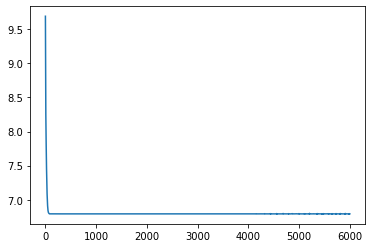

In [96]:
#train model on intensity 
model = train_tensor_regression(torch.tensor(tgt_intensity_train), x_stat_train, s_viz_train, max_itr = 6000, lr=1e-5)
yhat = model(x_stat_test, s_viz_test)
mae_intensity = mean_absolute_error(tgt_intensity_test*std_intensity + mean_intensity, yhat.detach().numpy()*std_intensity+mean_intensity)

In [97]:
mae_intensity

38.833145

final loss= 893.7818603515625


3.035211

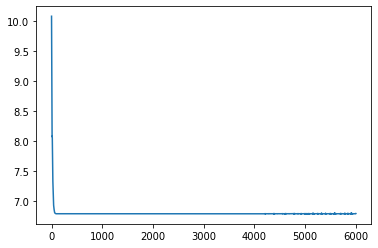

In [98]:
#train model on dx
tgt_dx_train,tgt_dx_test, mean_dx, std_dx  = standardize_y(tgt_displacement_train[:,0],tgt_displacement_test[:,0])
model = train_tensor_regression(torch.tensor(tgt_dx_train), x_stat_train, s_viz_train, max_itr = 6000, lr=1e-5)
yhat = model(x_stat_test, s_viz_test)
mae_dx = mean_absolute_error(tgt_dx_test*std_dx + mean_dx, yhat.detach().numpy()*std_dx+mean_dx)
mae_dx 

In [100]:
#train model on cat
# tgt_intensity_cat_train,tgt_intensity_cat_test, mean_cat, std_cat  = standardize_y(tgt_intensity_cat_train,tgt_intensity_cat_test)
model = train_tensor_regression(torch.tensor(tgt_intensity_cat_train), x_stat_train, s_viz_train, max_itr = 3000, lr=1e-4)
yhat = model(x_stat_test, s_viz_test)
mae_dx = mean_absolute_error(tgt_intensity_cat_test, yhat.round())
mae_dx 

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [23]:
def run_tensor_regression(vision_data, stat_data, window_size, predict_at,  core_ranks = [5,7,10,10]):
    #get training and test tensors
    ##maybe we don't have to call this for each prediction period, since x is the same, just y different?
    train_test_split=0.8
    train_tensors, test_tensors = Prepro.process(vision_data, stat_data, train_test_split, predict_at = predict_at, window_size=window_size)
    x_viz_train, x_stat_train, tgt_intensity_cat_train, tgt_intensity_cat_baseline_train, tgt_displacement_train, tgt_intensity_train = train_tensors
    x_viz_test, x_stat_test, tgt_intensity_cat_test, tgt_intensity_cat_baseline_test, tgt_displacement_test, tgt_intensity_test = test_tensors
    
    x_viz_train, x_viz_test, x_stat_train, x_stat_test = standardize_x(x_viz_train, x_viz_test, x_stat_train, x_stat_test)
    tgt_intensity_train,tgt_intensity_test, mean_intensity, std_intensity  = standardize_y(tgt_intensity_train,tgt_intensity_test)

    #compress viz data 
    s_viz_train, compression_error_train = viz_reduce(x_viz_train, core_ranks) #compress viz data 
    s_viz_test, compression_error_test = viz_reduce(x_viz_test, core_ranks) #compress viz data 
    
    
#     #train model on displacement 
#     y_train = tgt_displacement_train[:,0]
#     model = train_tensor_regression(y_train, x_stat_train, s_viz_train,lr=1e-5)
#     y_hat = model(x_stat_test, s_viz_test)
#     y_true = tgt_displacement_test[:,0]
#     error_dx = mean_absolute_error(y_true, y_hat.detach().numpy()) 

#     y_train2 = tgt_displacement_train[:,1]
#     model2 = train_tensor_regression(y_train2, x_stat_train, s_viz_train,lr=1e-5)
#     y_hat2 = model2(x_stat_test, s_viz_test)
#     y_true2= tgt_displacement_test[:,1]
#     error_dy= mean_absolute_error(y_true2, y_hat2.detach().numpy())
    
    #train model on intensity 
    model3 = train_tensor_regression(tgt_intensity_train, x_stat_train, s_viz_train, lr=5e-5)
    y_hat3 = model3(x_stat_test, s_viz_test)
    y_true3 = tgt_intensity_test
    mae_intensity = mean_absolute_error(tgt_intensity_test*std_intensity + mean_intensity, yhat*std_intensity+mean_intensity)
#     error_int_base = mean_absolute_error(y_true, tgt_intensity_baseline_test)
    
    return np.round(error_int,3) #np.round(error_dx,3) , np.round(error_dy,3), 
    

In [24]:
train_test_split = 0.1 #how much train test data
predict_at = 8 #steps_out
window_size = 16 #how many timesteps from the past to take ie steps_in

run_tensor_regression(vision_data, stat_data, window_size, predict_at, core_ranks = [5,7,10,10])

New dataset and corresponding sizes (null elements included):
X_vision torch.Size([3071, 16, 9, 25, 25])
X_stat torch.Size([3071, 16, 10])
target_displacement torch.Size([3071, 8, 2])
target_intensity torch.Size([3071])
target_intensity_cat torch.Size([3071])
target_intensity_cat_baseline torch.Size([3071])
Keeping 2481 samples out of the initial 3071.
Reshaping the displacement target...
approximation error= 19.674294117853165
approximation error= 18.796659583297053


RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

In [ ]:
core_ranks = [8,5,5,5]
s_viz_train, compression_error = viz_reduce(x_viz_train, core_ranks) #compress viz data 
print('compression_error=',compression_error)
s_viz_test, compression_error = viz_reduce(x_viz_test, core_ranks) #compress viz data 
print('compression_error=',compression_error)

final loss= 1453.5244140625
tensor_regression dx_mae 0.5257858
final loss= 1444.4901123046875
tensor_regression dy_mae 3.1421301


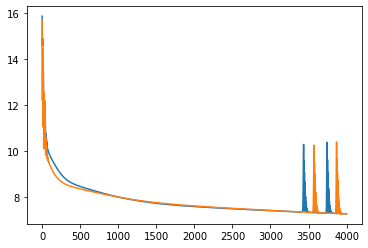

In [210]:
y_train = tgt_displacement_train[:,0]
model = train_tensor_regression(y_train, x_stat_train, s_viz_train,lr=1e-5)
y_hat = model(x_stat_test, s_viz_test)
y_true = tgt_displacement_test[:,0]
print("tensor_regression dx_mae", mean_absolute_error(y_true, y_hat.detach().numpy()))

y_train2 = tgt_displacement_train[:,1]
model = train_tensor_regression(y_train2, x_stat_train, s_viz_train,lr=1e-5)
y_hat2 = model(x_stat_test, s_viz_test)
y_true2= tgt_displacement_test[:,1]
print("tensor_regression dy_mae", mean_absolute_error(y_true2, y_hat2.detach().numpy()))


final loss= 1113.613037109375
accuracy score 0.6318114874815906
Baseline score 0.5949926362297496


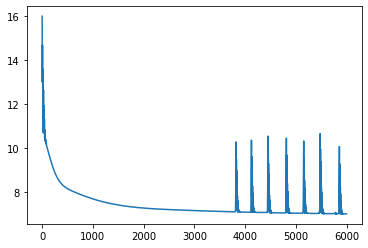

In [218]:
y_train = tgt_intensity_cat_train 
model = train_tensor_regression(y_train, x_stat_train, s_viz_train, max_itr=6000, lr=5e-5)
y_hat3 = model(x_stat_test, s_viz_test)
y_true = tgt_intensity_cat_test
print("accuracy score", accuracy_score(y_true, y_hat3.round().detach().numpy()))
print("Baseline score", accuracy_score(y_true, tgt_intensity_cat_baseline_test))